#  Hybrid Classical-Quantum Transfer Learning for Cardiomegaly Detection in Chest X-Rays 

## load data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import random
import os
import copy
        
import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset, Dataset
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset
from nngeometry.layercollection import LayerCollection
from nngeometry.metrics import FIM
from nngeometry.object import PMatKFAC, PMatDense
%matplotlib inline

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(123)
    
from watermark import watermark
%reload_ext watermark
%watermark 
%watermark --iversions

Last updated: 2023-02-26T10:29:47.180200+08:00

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.8.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
CPU cores   : 24
Architecture: 64bit

seaborn    : 0.12.2
torchvision: 0.14.1
torch      : 1.13.1
numpy      : 1.23.5
matplotlib : 3.6.3
pandas     : 1.5.3



In [2]:
import time
n_qubits = 4                     # Number of qubits.
q_depth = 6                      # Depth of the quantum circuit (number of variational layers).
max_layers = 15                  # Keep 15 even if not all are used.
q_delta = 0.01                   # Initial spread of random quantum weights.

step = 10e-4                     # Learning rate.
weight_decay = 10e-4             # Weight_decay for learning rate.
batch_size = 8                   # Number of samples for each training step.
init_epochs = 0                  # Number of init epochs.
train_epochs = 20                # Number of training epochs.
step_size= 2                     # Learning rate changing epochs.
gamma_lr_scheduler = 0.3         # Learning rate reduction applied every step_size epochs.  

start_time = time.time()         # Start of the computation timer

In [3]:
from tqdm import tqdm 
import time
start = time.time()
img_size = 256

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_size, img_size)), 
        transforms.CenterCrop((224,224)),
        #transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAutocontrast(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}


data_dir = 'chexpert-corrected/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                     data_transforms[x]) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Initialize dataloader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size, shuffle=True) for x in ['train', 'val']}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # We apply the inverse of the initial normalization operation.
    if transforms.Normalize in data_transforms['val'].transforms:
        norm = tranform_start[trans_list.index(transforms.Normalize)]
        mean = np.array(norm.mean)#np.array([0.485, 0.456, 0.406])
        std = np.array(norm.std)#np.array([0.229, 0.224, 0.225])
        img = std * input_tensor + mean  
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

own_elapsed = time.time() - start
print("Time elapsed: ", own_elapsed)

Time elapsed:  0.010511398315429688


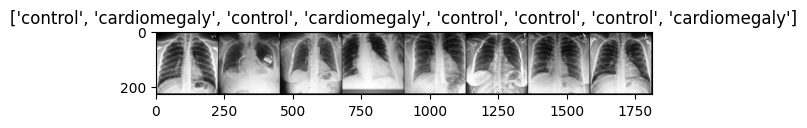

In [4]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
#resize image
import cv2
import PIL
from glob import glob

def read_img(img_path,tranform_):
    img = cv2.imread(img_path)
    transform = transforms.Compose(tranform_)
    img = transform(PIL.Image.fromarray(img))
    return img

print('Scans found:', len(image_datasets['train'].imgs)+ len(image_datasets['val'].imgs))

Scans found: 2436


### GradCam

In [6]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50,resnext50_32x4d,resnet18,densenet161,wide_resnet50_2, densenet121, densenet161
from PIL import Image

### pre-process dataset
generate image from address

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#device = 'cpu' #qiskit don't support gpu on windows

cuda:0


In [8]:
from tqdm import tqdm 
train_img = []
train_ids = []
train_y = []

img_size=256
tranform_ = [transforms.Resize((img_size, img_size)), 
             transforms.CenterCrop((224,224)),
             #transforms.RandomRotation(30),
             #transforms.RandomHorizontalFlip(p=0.5),
             #transforms.RandomAutocontrast(p=0.5),
             #transforms.ToTensor(),
             #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]

train_img = []
train_ids = []
train_y = []

for img_path in tqdm(image_datasets["train"].imgs):
    train_img.append(read_img(img_path[0],tranform_))
    train_ids.append(img_path[0].split("\\")[2])
    train_y.append(img_path[1])
    
#valid_img = []
#valid_ids = []
#valid_y = []
#
#for img_path in tqdm(image_datasets["val"].imgs):
#    valid_img.append(read_img(img_path[0],tranform_))
#    valid_ids.append(img_path[0].split("\\")[2])
#    valid_y.append(img_path[1])
    
test_img = []
test_ids = []
test_y = []
for img_path in tqdm(image_datasets["val"].imgs):
    test_img.append(read_img(img_path[0],tranform_))
    test_ids.append(img_path[0].split("\\")[2])
    test_y.append(img_path[1])

100%|███████████████████████████████████████████████████████████████████████████████| 730/730 [00:01<00:00, 722.44it/s]


In [9]:
#qamp_IMAGE_DIR = "qamp"

import time
start = time.time()

# * better way

tranform_ = [#transforms.Resize((img_size, img_size)), 
             #transforms.CenterCrop((224,224)),
             #transforms.RandomRotation(30),
             #transforms.RandomHorizontalFlip(p=0.5),
            #transforms.RandomVerticalFlip(p=0.5),
             #transforms.RandomAutocontrast(p=1.0),
             transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
transform = transforms.Compose(tranform_)

train_imgg = []
for img in tqdm(train_img):
    img = transform(img)
    train_imgg.append(img)
##train_ds=torch.tensor(np.array(train_img), device=device).float()
train_y = torch.tensor(train_y, device=device).float()
train_ds = TensorDataset(torch.stack(train_imgg).to(device), train_y)
train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=True)
train_size = len(train_dataloader)

tranform_ = [#transforms.Resize((img_size, img_size)), 
             #transforms.CenterCrop((224,224)),
             #transforms.RandomRotation(30),
             #transforms.RandomHorizontalFlip(p=0.5),
             #transforms.RandomAutocontrast(p=1.0),
             transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
transform = transforms.Compose(tranform_)

#valid_imgg=[]
#for img in tqdm(valid_img):
#    img = transform(img)
#    valid_imgg.append(img)
###valid_ds=torch.tensor(np.array(valid_img), device=device).float()
#valid_y = torch.tensor(valid_df['Cardiomegaly'].values, device=device).float()
#valid_ds = TensorDataset(torch.stack(valid_imgg).to(device), valid_y)
#valid_dataloader = torch.utils.data.DataLoader(valid_ds, batch_size=2, shuffle=True)
#valid_size = len(valid_dataloader)

test_img_ = []
for img in tqdm(test_img):
    img = transform(img)
    test_img_.append(img)
#test_ds=torch.tensor(np.array(test_img_), device=device).float()
test_y = torch.tensor(test_y, device=device).float()
test_ds = TensorDataset(torch.stack(test_img_).to(device), test_y)
test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False)#, sampler= sampler)


own_elapsed = time.time() - start
print("Time elapsed: ", own_elapsed)

100%|██████████████████████████████████████████████████████████████████████████████| 730/730 [00:00<00:00, 1115.83it/s]


Time elapsed:  3.92864990234375


## Neural Network

In [10]:
# install instruction - https://www.delftstack.com/howto/python/python-graphviz-executables-are-not-found/
#from torchviz import make_dot
#
#model = resnet18()
#batch = next(iter(train_dataloader))[0]
##x = torch.zeros(1, 3, 224, 224, dtype=torch.float, requires_grad=False)#8, 3, 224, 224
#yhat = model(batch) # Give dummy batch to forward().
#make_dot(yhat, params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")

In [11]:
from math import pi
from scipy.special import logsumexp
import numpy as np


# This class is used to calculate the effective dimension of a model (classical or quantum)
# It implicitly computed the normalised Fisher information (which is called fhat) and then computes the eff dimension


class EffectiveDimension:
    def __init__(self, model, num_thetas, num_inputs):
        """
        Computes the effective dimension for a parameterised model.
        :param model: class instance
        :param num_thetas: int, number of parameter sets to include
        :param num_inputs: int, number of input samples to include
        """
        self.model = model
        self.d = model.d
        self.num_thetas = num_thetas
        self.num_inputs = num_inputs
        # Stack data together and combine parameter sets to make calcs more efficient
        rep_range = np.tile(np.array([num_inputs]), num_thetas)
        params = np.random.uniform(self.model.thetamin, self.model.thetamax, size=(self.num_thetas, model.d))
        self.params = np.repeat(params, repeats=rep_range, axis=0)
        x = np.random.normal(0, 1, size=(self.num_inputs, self.model.inputsize))
        self.x = np.tile(x, (self.num_thetas, 1))

    def get_fhat(self):
        """
        :return: ndarray, f_hat values of size (num_inputs, d, d)
        """
        grads = self.model.get_gradient(params=self.params, x=self.x)  # get gradients, dp_theta
        output = self.model.forward(params=self.params, x=self.x)  # get model output
        fishers = self.model.get_fisher(gradients=grads, model_output=output)
        fisher_trace = np.trace(np.average(fishers, axis=0))  # compute the trace with all fishers
        # average the fishers over the num_inputs to get the empirical fishers
        fisher = np.average(np.reshape(fishers, (self.num_thetas, self.num_inputs, self.d, self.d)), axis=1)
        f_hat = self.d * fisher / fisher_trace  # calculate f_hats for all the empirical fishers
        return f_hat, fisher_trace

    def eff_dim(self, f_hat, n):
        """
        Compute the effective dimension.
        :param f_hat: ndarray
        :param n: list, used to represent number of data samples available as per the effective dimension calc
        :return: list, effective dimension for each n
        """
        effective_dim = []
        for ns in n:
            Fhat = f_hat * ns / (2 * pi * np.log(ns))
            one_plus_F = np.eye(self.d) + Fhat
            det = np.linalg.slogdet(one_plus_F)[1]  # log det because of overflow
            r = det / 2  # divide by 2 because of sqrt
            effective_dim.append(2 * (logsumexp(r) - np.log(self.num_thetas)) / np.log(ns / (2 * pi * np.log(ns))))
        return effective_dim

### Quantum layer

In [12]:
import pennylane as qml
dev = qml.device('default.qubit', wires=n_qubits)

In [13]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates. 
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)
        
def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis. 
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    #CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT  
    for i in range(0, nqubits - 1, 2): #loop over even indices: i=0,2,...N-2  
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2): #loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [14]:
@qml.qnode(dev, interface='torch') 
def q_net(q_in, q_weights_flat):
        
        # Reshape weights
        q_weights = q_weights_flat.reshape(max_layers, n_qubits)
        
        # Start from state |+> , unbiased w.r.t. |0> and |1>
        H_layer(n_qubits)   
        
        # Embed features in the quantum node
        RY_layer(q_in)
        
       
        # Sequence of trainable variational layers
        for k in range(q_depth):
            entangling_layer(n_qubits)
            RY_layer(q_weights[k + 1])

        # Expectation values in the Z basis
        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

### training function

In [15]:
import copy
from torchsummary import summary as quick_sum # this is buggy, but light
from torchinfo import summary # this is good, but take a lot of memory
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, auc, roc_curve, accuracy_score,confusion_matrix,classification_report
save_result = True
if save_result == True:
    # create folder and save the result
    time_str = time.strftime("%Y%m%d-%H%M%S")
    result_OUT = f"image_result/no_freezer_{time_str}"
    os.makedirs(result_OUT, exist_ok=True)

In [16]:
def get_variable_name(variable):
    globals_dict = globals()

    return [var_name for var_name in globals_dict if globals_dict[var_name] is variable]

In [17]:
def conf_matrix(y, y_pred):
    fig, ax =plt.subplots(figsize=(3.5,3.5))
    labels=['No','Yes']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title('Cardiomegaly?', fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test')
    ax.set_xlabel('Predicted')

In [18]:
def grad_camera(models, target_layers, picture_select, transform_start=None, transform_end=None,name=None):
    """ Train function
    Args:
        models: pytroch model
        target_layers :  target layer of the model
        picture_select (str): select picture from all the image
        transform_start : input picture display
        transform_end : output picture display
    Returns:
        pytorch model
    Raises:
        None
    """
    #target_layers = target_layers
    # need modify yourself
    if transform_start == None:
        tranform_start = [transforms.Resize((img_size, img_size)), 
                        transforms.CenterCrop((224,224)),
                        #transforms.RandomRotation(30),
                        #transforms.RandomHorizontalFlip(p=0.5),
                        #transforms.RandomAutocontrast(p=0.5),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        ]
        #return tranform_start
    input_tensor = torch.stack([read_img(eval(f'image_datasets["train"].imgs{picture_select}[0]'), tranform_start)])#torch.stack(train_img)[:1,:,:,:]# Create an input tensor image for your model..
    print(input_tensor.numpy()[0].shape)
    y= models(input_tensor.to(device))
    # Note: input_tensor can be a batch tensor with several images!
    
    # Construct the CAM object once, and then re-use it on many images:
    cam = GradCAMPlusPlus(model=models, target_layers=target_layers)#, use_cuda=False)
    
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor.to(device))[0, :]#, targets=targets)[0, :]
    
    # In this example grayscale_cam has only one image in the batch:
    if transform_end == None:
        trans_list = list(map(type, tranform_start))
        input_tensor = input_tensor.numpy()[0]
        input_tensor = np.transpose(input_tensor, (1,2,0))
        if transforms.Normalize in trans_list:
            #img = np.transpose(input_tensor, (1,2,0))
            # We apply the inverse of the initial normalization operation.
            norm = tranform_start[trans_list.index(transforms.Normalize)]
            mean = np.array(norm.mean)#np.array([0.485, 0.456, 0.406])
            std = np.array(norm.std)#np.array([0.229, 0.224, 0.225])
            img = std * input_tensor + mean  
            input_tensor = np.clip(img, 0, 1)
    #img= read_img(eval(f'list(all_image_paths.values()){picture_select}'), transform_end)
    #img =np.float32(img) / 255
    visualization = show_cam_on_image(input_tensor, grayscale_cam, use_rgb=True)
    
    
    #_, y_prob = torch.max(y, 1)
    y_probb = nn.Sigmoid()(y)[0]
    df = image_datasets["train"].imgs
    plt.title(f'Cardiomegaly?\n true:{eval(f"df{picture_select}[1]")}\n pred[no/yes]:{np.round(y_probb.cpu().detach().numpy(),3)}', fontsize=20)
    #Image.fromarray(visualization, 'RGB')
    plt.imshow(visualization)
    if (save_result == True and name != None): plt.savefig(f"{result_OUT}/{name}_visual_img.png")
    return visualization

In [19]:
def train_model(model, criterion, optimizer,scheduler, num_epochs, loss_save=None, scheduler_set = ["outside_train"], sig_out = True,transform = True, save = True):
    """ Train function
    Args:
        model : pytroch model
        criterion :  Criterion
        optimizer : optimize
        scheduler : scheduler
        num_epochs (int): Number of epochs
        loss_save (bool): select model save condition, 
            it can be 'None' for best_loss_train, 'True' for best_acc or False for best_loss (default=None)
        scheduler_set (list): The set the scheduler place, 
            it can include ('inside_train', 'outside_train', 'inside_valid', 'outside_valid', outside_loss_valid)
        sig_out (bool): training sigmoid output
        transform (bool): transform each epoch
    Returns:
        pytorch model
    Raises:
        None
    """
    #qamp_IMAGE_DIR = "qamp"
    start = time.time()
    
    #layer_collection = LayerCollection.from_model(model)
    #d = layer_collection.numel()
    #print('d= ', d)
    name = get_variable_name(model)[0]
    print('name:',name)
    
    #train_ds=torch.tensor(np.array(train_img), device=device).float()
    
    
    #own_elapsed = time.time() - start
    #print("loader Time elapsed: ", own_elapsed)
    global train_ds
    global train_dataloader
    #global valid_ds
    #global valid_dataloader
    
    train_loss = []
    train_loss_list = []
    training_loss = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0   # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    opt_rate=[]
    for epoch in range(num_epochs):
        if transform:
            trans_start = time.time()
            tranform_ = [#transforms.Resize((img_size, img_size)), 
                 #transforms.CenterCrop((224,224)),
                 #transforms.RandomRotation(30),
                 transforms.RandomHorizontalFlip(p=.5),
                 #transforms.RandomVerticalFlip(p=.5),
                 #transforms.RandAugment(),
                 #transforms.RandomAdjustSharpness(sharpness_factor=2),
                 #transforms.RandomSolarize(threshold=192.0),
                 #transforms.RandomSolarize(threshold=192.0),
                 #transforms.RandomInvert(),
                 transforms.RandomAutocontrast(p=.5),
                 transforms.ToTensor(),
                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ]
            transform = transforms.Compose(tranform_)
            
            train_imgg = []
            for img in train_img:
                img = transform(img)
                train_imgg.append(img)
            
            train_ds = TensorDataset(torch.stack(train_imgg).to(device), train_y)
            train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=True)
            
            #valid_imgg=[]
            #for img in valid_img:
            #    img = transform(img)
            #    valid_imgg.append(img)
            #valid_ds = TensorDataset(torch.stack(valid_imgg).to(device), valid_y)
            #valid_dataloader = torch.utils.data.DataLoader(valid_ds, batch_size=2, shuffle=False)
            
            print("Transform Time elapsed: ", time.time() - trans_start)
        
        train_size = len(train_dataloader)
        #valid_size = len(valid_dataloader)
        
        running_loss = 0.0
        running_corrects = 0
        print(epoch+1,'Training started:')
        #for dataset_size_multiplier in range(5):
        for index, data in enumerate(tqdm(train_dataloader)):
            inputs, labels = data[0].to(device).type(torch.float), data[1].to(device).type(torch.long)
            #running_loss = 0.0
            # Set model to training mode
            model.train() 
            
            # Each epoch has a training and validation phase
            batch_size_ = len(inputs)
            optimizer.zero_grad()
            
            # Iterate over data.
            #n_batches = dataset_sizes[phase] // batch_size
            # Track/compute gradient and make an optimization step only when training
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                #nn.sigmoid(outputs)
                #print(outputs)
                if len(outputs.shape) == 1:
                    outputs = torch.stack([outputs])
                if sig_out == True:
                    outputs = nn.Sigmoid()(outputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)#torch.stack(label_list))
                loss.backward()
                optimizer.step()
                if "inside_train" in scheduler_set:
                    scheduler.step()
                
            
            # Print iteration results
            running_loss += loss.item() #*inputs.size(0)#* batch_size_
            train_loss.append(loss.item() )#*inputs.size(0))#*batch_size_)
            batch_corrects = torch.sum(preds == labels.data).item()
            running_corrects += batch_corrects
            if (index+1)%train_size == 0:
                #print(outputs)
                #print(preds)
                print('Train Epoch: {}/{} train loss {:.4f} Acc batch: {:.4f} learning_rate: {:.4f}'.format(epoch + 1, num_epochs, running_loss/train_size, running_corrects/train_ds.tensors[0].size(0),optimizer.state_dict()['param_groups'][0]['lr']))
                training_loss.append(running_loss/train_size)
        if running_corrects/len(train_ds) > best_acc_train:
            best_acc_train = running_loss
        if running_loss < best_loss_train:
            best_loss_train = running_corrects/len(train_ds)#round(new_train_df.shape[0]*split_size)
        if "outside_train" in scheduler_set:
            scheduler.step()
                
        train_loss_list.append(np.mean(train_loss))
        #opt_rate.append(optimizer.state_dict()['param_groups'][0]['lr'])
    if save_result: np.savetxt(f"{result_OUT}/{name}_training_loss.csv", training_loss)#save
    if save_result: np.savetxt(f"{result_OUT}/{name}_train_loss.csv", train_loss)#save
    if save_result: np.savetxt(f"{result_OUT}/{name}_train_loss_list.csv", train_loss_list)#save
            
    own_elapsed = time.time() - start
    print("Time elapsed: ", own_elapsed)
    
    # Print final results 
    #if loss_save != None:
    #    model.load_state_dict(best_model_wts)
    #print('Best test loss: {:.4f} | Best test accuracy: {:.4f}'.format(best_loss, best_acc))
    if len(train_loss_list) > 1:
        plt.rcParams["figure.figsize"] = (5.5, 4)
        plt.title("Training loss against Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Training loss")
        plt.plot(range(0,len(train_loss_list)), train_loss_list, color="blue")
        if save_result == True: plt.savefig(f"{result_OUT}/{name}_train_loss.png")#save pic
        plt.show()
    if save:
        running_loss = 0.0
        with torch.no_grad():
            model.eval()
            
            y_pred = []
            for index, data in enumerate(tqdm(test_dataloader)):
                model.eval()
                batch_inputs, batch_labels = data[0].to(device).type(torch.float), data[1].to(device).type(torch.long)
                with torch.set_grad_enabled(False):
                    outputs = model(batch_inputs)
                    y_pred.append(outputs[0])
                    #assert isinstance(outputs.item(), float)
                    #print(outputs, batch_labels)
                    #if len(outputs.shape) == 1:
                    #    outputs = torch.stack([outputs])
                    if sig_out == True:
                        outputs = nn.Sigmoid()(outputs)
                    #_, preds = torch.max(outputs, 1)
                    loss    = criterion(outputs, batch_labels)
                #print(f"Step {index} loss: {loss}")
                running_loss += loss.item()
            _, y_pred_prob = torch.max(torch.stack(y_pred), 1)
            y_pred_prob = y_pred_prob.cpu()
            if save_result == True: np.savetxt(f"{result_OUT}/{name}_test_loss.csv", y_pred_prob)#save
            #print(y_pred, y_pred_prob)
            print(classification_report(test_y.cpu().long(), torch.tensor(y_pred_prob.detach().numpy()),digits=4))
            conf_matrix(test_y.cpu().long(), y_pred_prob)
            if save_result == True: plt.savefig(f"{result_OUT}/{name}_conf_matrix.png")#save pic
            plt.figure(figsize = (5.5, 4))
            fpr, tpr, _ =roc_curve(test_y.cpu().long(), torch.tensor(y_pred_prob.detach().numpy()))
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
            plt.plot([0, 1], [0, 1],'r--')
            plt.title('ROC curve',fontsize=25)
            plt.ylabel('True Positive Rate',fontsize=18)
            plt.xlabel('False Positive Rate',fontsize=18)
            plt.legend(loc = 'lower right', fontsize=24, fancybox=True, shadow=True, frameon=True, handlelength=0)
            if save_result == True: plt.savefig(f"{result_OUT}/{name}_roc.png") #save pic
            plt.show()
    return model

## init_freezer

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
def n_count_parameters(model):
    return sum(p.numel() for p in model.parameters() if not(p.requires_grad))

In [21]:
def train_func(cnn_model,init_step, train_step,save_model=save_result):
    criterion = nn.CrossEntropyLoss()
    if init_step > 0:
        optimizer = torch.optim.Adam(cnn_model.parameters(), lr=step, weight_decay = weight_decay)
        #optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, cnn_model.parameters()), lr=10e-4, momentum=0.9)
        exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma_lr_scheduler)
        cnn_model = train_model(cnn_model.to(device), 
                                criterion, optimizer,exp_lr_scheduler, 
                                init_step,None,["outside_train"], False, True,False)
    
    for param in cnn_model.parameters():
        param.requires_grad = True
    
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=(step*0.3)*(np.floor(init_step/2)) if init_step > 0  else step, weight_decay = weight_decay)
    #optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, cnn_model.parameters()), lr=3e-4, momentum=0.9)
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma_lr_scheduler)
    cnn_model = train_model(cnn_model.to(device), 
                            criterion, optimizer,exp_lr_scheduler, 
                            train_step,None,["outside_train"], False, True)#["outside_train"]
    
    cnn_model_visual = grad_camera(cnn_model, [cnn_model.features[-1]],[0] ,transform_start=None, transform_end=None,name=get_variable_name(cnn_model)[0])
    if save_model:
        torch.save(cnn_model.state_dict(),f"{result_OUT}/{get_variable_name(cnn_model)[0]}.pt")
    return cnn_model

In [22]:
def prob_loop(sample,models, target_layers, picture_select, transform_start=None, transform_end=None,name=None):
    # need modify yourself
    if transform_start == None:
        tranform_start = [transforms.Resize((img_size, img_size)), 
                        transforms.CenterCrop((224,224)),
                        #transforms.RandomRotation(30),
                        #transforms.RandomHorizontalFlip(p=0.5),
                        #transforms.RandomAutocontrast(p=0.5),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        ]
    input_tensor = torch.stack([read_img(eval(f'image_datasets[sample].imgs{picture_select}[0]'), tranform_start)])#torch.stack(val_img)[:1,:,:,:]# Create an input tensor image for your model..
    y= models(input_tensor.to(device))
    
    y_probb = nn.Sigmoid()(y)[0]
    return y_probb


def make_df_y_probb(sample,model) :  
    df_y_probb = pd.DataFrame(columns=['image', 'p_yes', 'p_no'])
    df = image_datasets[sample].imgs
    for i in tqdm(range(len(df))):
        image_name = df[i][0][-10:]
        y_probb = prob_loop(sample, model, [model.features[-1]] \
            ,[i] ,transform_start=None, transform_end=None)
        y_probb = y_probb.cpu()
        p_yes = y_probb.detach().numpy()[0]
        p_no = y_probb.detach().numpy()[1]
        row = {'image' : image_name, 'p_yes': p_yes, 'p_no': p_no}
        new_df = pd.DataFrame([row])
        df_y_probb =  pd.concat([df_y_probb, new_df], axis = 0, ignore_index=True)
    return df_y_probb

def plot_ROC(name,y_true, y_score):

    # ROC Curve and AUROC
    plt.figure(0).clf()
    if np.sum(y_true) != 0.:        
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc = round(roc_auc_score(y_true, y_score), 4)
        plt.plot(fpr,tpr,label=name + ", AUC =" + str(auc))
    if save_result == True: plt.savefig(f"{result_OUT}/{name}_roc.png") #save pic
    plt.legend()
    plt.show()

def make_csv(model, sample="val",result=True):
    df = make_df_y_probb(sample,model)
    if sample == "val":
        df_list = 361*[1] + 369*[0]
    elif sample == "train":
        df_list = 850*[1] + 856*[0]
    df = df.assign(label = df_list)

    pred_list = np.array(df.p_yes) / (np.array(df.p_yes) + np.array(df.p_no))
    df = df.assign(cmg_pred = pred_list)
    #elif sample == "train":
    #    pred_val_list =( np.array(df.p_yes) / (np.array(df.p_yes) + np.array(df.p_no)) + 0.5).astype('int32')
    #    df = df.assign(pred = pred_val_list)
    
    pred_list =( np.array(df.p_yes) / (np.array(df.p_yes) + np.array(df.p_no)) + 0.5).astype('int32')
    df = df.assign(pred = pred_list)
    
    df = df.rename(columns={"cmg_pred": "prob"})
    if sample == "val":
        df.sort_values(by = 'image')[0:16]
    elif sample == "train":
        df.sort_values(by = 'image')
    if save_result: df.to_csv(f'{result_OUT}/y_probbs_{get_variable_name(model)[0]}_{sample}.csv', index = False)
    
    if result:
        name = get_variable_name(model)[0]
        df_val = pd.read_csv(f'{result_OUT}/y_probbs_{name}_{sample}.csv') 
        prediction = np.array(df_val.prob) 
        name_ROC = f"Cardiomegaly - {name}_{sample}"
        plot_ROC(name_ROC, np.array(df_val.label), prediction)
        print(classification_report(np.array(df_val.label),  (prediction+ 0.5).astype('int32')))#prediction))
    return df

### densenet121


name: densenet121_model
Transform Time elapsed:  2.559776782989502
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:51<00:00,  4.15it/s]

Train Epoch: 1/20 train loss 0.5611 Acc batch: 0.7397 learning_rate: 0.0010


Transform Time elapsed:  2.7689552307128906
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:50<00:00,  4.23it/s]

Train Epoch: 2/20 train loss 0.4989 Acc batch: 0.7808 learning_rate: 0.0010


Transform Time elapsed:  2.734896421432495
3 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:50<00:00,  4.22it/s]

Train Epoch: 3/20 train loss 0.4293 Acc batch: 0.8113 learning_rate: 0.0003


Transform Time elapsed:  2.820127248764038
4 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:50<00:00,  4.25it/s]

Train Epoch: 4/20 train loss 0.4295 Acc batch: 0.8118 learning_rate: 0.0003


Transform Time elapsed:  2.891312837600708
5 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:50<00:00,  4.22it/s]

Train Epoch: 5/20 train loss 0.3676 Acc batch: 0.8476 learning_rate: 0.0001


Transform Time elapsed:  2.7063117027282715
6 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:51<00:00,  4.16it/s]

Train Epoch: 6/20 train loss 0.3622 Acc batch: 0.8453 learning_rate: 0.0001


Transform Time elapsed:  2.6939897537231445
7 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:50<00:00,  4.24it/s]

Train Epoch: 7/20 train loss 0.3290 Acc batch: 0.8658 learning_rate: 0.0000


Transform Time elapsed:  2.7635533809661865
8 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:51<00:00,  4.19it/s]

Train Epoch: 8/20 train loss 0.3291 Acc batch: 0.8652 learning_rate: 0.0000


Transform Time elapsed:  3.2771716117858887
9 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:51<00:00,  4.19it/s]

Train Epoch: 9/20 train loss 0.3329 Acc batch: 0.8658 learning_rate: 0.0000


Transform Time elapsed:  2.810455322265625
10 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:51<00:00,  4.18it/s]

Train Epoch: 10/20 train loss 0.3326 Acc batch: 0.8646 learning_rate: 0.0000


Transform Time elapsed:  2.9032535552978516
11 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:50<00:00,  4.22it/s]

Train Epoch: 11/20 train loss 0.3126 Acc batch: 0.8804 learning_rate: 0.0000


Transform Time elapsed:  2.7065072059631348
12 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:51<00:00,  4.15it/s]

Train Epoch: 12/20 train loss 0.3060 Acc batch: 0.8722 learning_rate: 0.0000


Transform Time elapsed:  2.743821859359741
13 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:50<00:00,  4.22it/s]

Train Epoch: 13/20 train loss 0.2939 Acc batch: 0.8916 learning_rate: 0.0000


Transform Time elapsed:  2.8740553855895996
14 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:50<00:00,  4.26it/s]

Train Epoch: 14/20 train loss 0.3071 Acc batch: 0.8751 learning_rate: 0.0000


Transform Time elapsed:  2.7883219718933105
15 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:50<00:00,  4.24it/s]

Train Epoch: 15/20 train loss 0.3180 Acc batch: 0.8769 learning_rate: 0.0000


Transform Time elapsed:  2.6882128715515137
16 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:51<00:00,  4.12it/s]

Train Epoch: 16/20 train loss 0.3027 Acc batch: 0.8781 learning_rate: 0.0000


Transform Time elapsed:  2.7827224731445312
17 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:50<00:00,  4.25it/s]

Train Epoch: 17/20 train loss 0.3099 Acc batch: 0.8775 learning_rate: 0.0000


Transform Time elapsed:  2.838150978088379
18 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:50<00:00,  4.24it/s]

Train Epoch: 18/20 train loss 0.2909 Acc batch: 0.8822 learning_rate: 0.0000


Transform Time elapsed:  2.85699725151062
19 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:51<00:00,  4.17it/s]

Train Epoch: 19/20 train loss 0.3175 Acc batch: 0.8734 learning_rate: 0.0000


Transform Time elapsed:  2.67401123046875
20 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:50<00:00,  4.22it/s]

Train Epoch: 20/20 train loss 0.3052 Acc batch: 0.8722 learning_rate: 0.0000
Time elapsed:  1073.6580939292908


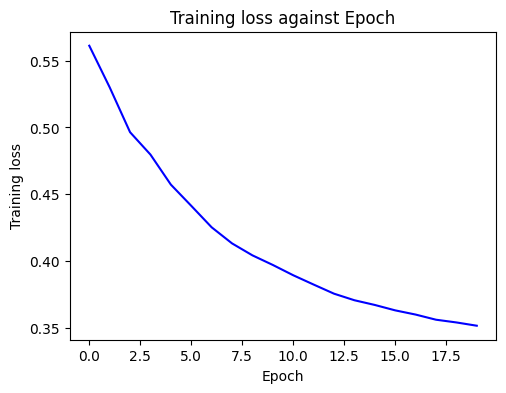

100%|████████████████████████████████████████████████████████████████████████████████| 730/730 [00:49<00:00, 14.85it/s]


              precision    recall  f1-score   support

           0     0.8920    0.8006    0.8438       361
           1     0.8227    0.9051    0.8619       369

    accuracy                         0.8534       730
   macro avg     0.8573    0.8529    0.8529       730
weighted avg     0.8569    0.8534    0.8530       730



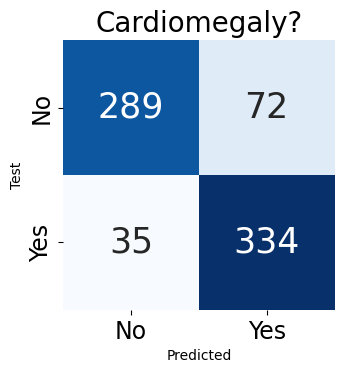

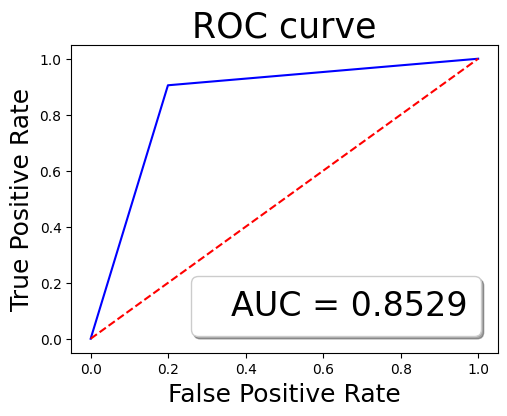

(3, 224, 224)


100%|██████████████████████████████████████████████████████████████████████████████| 1706/1706 [02:01<00:00, 13.99it/s]


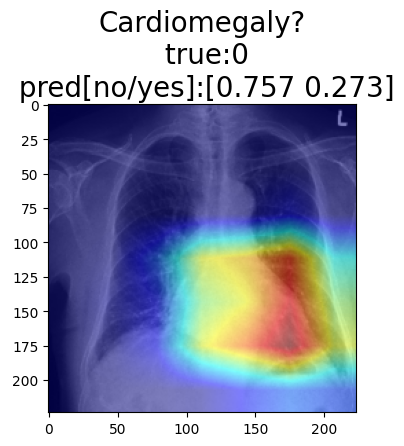

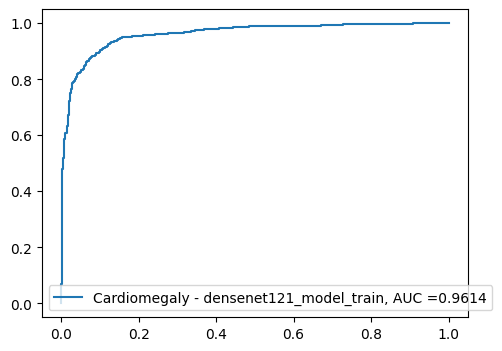

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       856
           1       0.92      0.87      0.89       850

    accuracy                           0.90      1706
   macro avg       0.90      0.90      0.90      1706
weighted avg       0.90      0.90      0.90      1706



100%|████████████████████████████████████████████████████████████████████████████████| 730/730 [00:51<00:00, 14.05it/s]


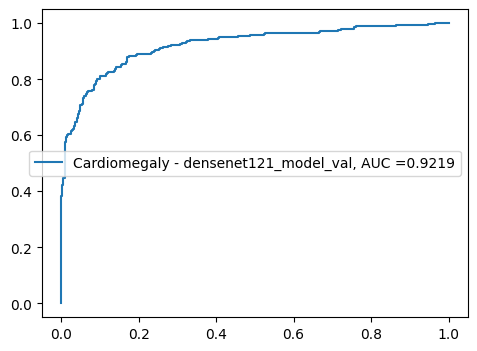

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       369
           1       0.89      0.80      0.84       361

    accuracy                           0.85       730
   macro avg       0.86      0.85      0.85       730
weighted avg       0.86      0.85      0.85       730



In [23]:
densenet121_model = torchvision.models.densenet121(weights= 'DEFAULT')
for param in densenet121_model.parameters():
    param.requires_grad = False
densenet121_model.classifier = nn.Sequential(nn.Linear(densenet121_model.classifier.in_features, 512), torch.nn.ReLU(), nn.Linear(512, 2))
densenet121_model = train_func(densenet121_model, init_epochs, train_epochs)

for i in ['train','val']:
    exec(f"densenet121_model_{i}=make_csv(densenet121_model,'{i}')")

### AlexNet hybird

name: alexnet_model
Transform Time elapsed:  2.778441905975342
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 37.69it/s]


Train Epoch: 1/20 train loss 0.7461 Acc batch: 0.4924 learning_rate: 0.0010
Transform Time elapsed:  2.6855015754699707
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.90it/s]


Train Epoch: 2/20 train loss 0.7009 Acc batch: 0.4924 learning_rate: 0.0010
Transform Time elapsed:  2.7149105072021484
3 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.80it/s]


Train Epoch: 3/20 train loss 0.6827 Acc batch: 0.5651 learning_rate: 0.0003
Transform Time elapsed:  2.7665183544158936
4 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.17it/s]


Train Epoch: 4/20 train loss 0.6489 Acc batch: 0.6342 learning_rate: 0.0003
Transform Time elapsed:  2.664595127105713
5 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.70it/s]


Train Epoch: 5/20 train loss 0.4736 Acc batch: 0.7907 learning_rate: 0.0001
Transform Time elapsed:  2.7219021320343018
6 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.67it/s]


Train Epoch: 6/20 train loss 0.4075 Acc batch: 0.8236 learning_rate: 0.0001
Transform Time elapsed:  2.719122886657715
7 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.85it/s]


Train Epoch: 7/20 train loss 0.3736 Acc batch: 0.8347 learning_rate: 0.0000
Transform Time elapsed:  2.6341376304626465
8 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.09it/s]


Train Epoch: 8/20 train loss 0.3515 Acc batch: 0.8464 learning_rate: 0.0000
Transform Time elapsed:  2.6882834434509277
9 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.46it/s]


Train Epoch: 9/20 train loss 0.3394 Acc batch: 0.8564 learning_rate: 0.0000
Transform Time elapsed:  2.786388874053955
10 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.24it/s]


Train Epoch: 10/20 train loss 0.3293 Acc batch: 0.8658 learning_rate: 0.0000
Transform Time elapsed:  2.7278177738189697
11 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.51it/s]


Train Epoch: 11/20 train loss 0.3365 Acc batch: 0.8570 learning_rate: 0.0000
Transform Time elapsed:  2.694925308227539
12 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.15it/s]


Train Epoch: 12/20 train loss 0.3299 Acc batch: 0.8599 learning_rate: 0.0000
Transform Time elapsed:  2.776165246963501
13 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.21it/s]


Train Epoch: 13/20 train loss 0.3308 Acc batch: 0.8552 learning_rate: 0.0000
Transform Time elapsed:  2.6422929763793945
14 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.73it/s]


Train Epoch: 14/20 train loss 0.3259 Acc batch: 0.8593 learning_rate: 0.0000
Transform Time elapsed:  2.850015640258789
15 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 39.62it/s]


Train Epoch: 15/20 train loss 0.3278 Acc batch: 0.8628 learning_rate: 0.0000
Transform Time elapsed:  2.756031036376953
16 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.20it/s]


Train Epoch: 16/20 train loss 0.3249 Acc batch: 0.8623 learning_rate: 0.0000
Transform Time elapsed:  2.6775712966918945
17 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.18it/s]


Train Epoch: 17/20 train loss 0.3215 Acc batch: 0.8558 learning_rate: 0.0000
Transform Time elapsed:  2.6025211811065674
18 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.25it/s]


Train Epoch: 18/20 train loss 0.3297 Acc batch: 0.8587 learning_rate: 0.0000
Transform Time elapsed:  2.718416929244995
19 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.38it/s]


Train Epoch: 19/20 train loss 0.3258 Acc batch: 0.8623 learning_rate: 0.0000
Transform Time elapsed:  2.649791955947876
20 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.21it/s]


Train Epoch: 20/20 train loss 0.3177 Acc batch: 0.8640 learning_rate: 0.0000
Time elapsed:  171.17897033691406


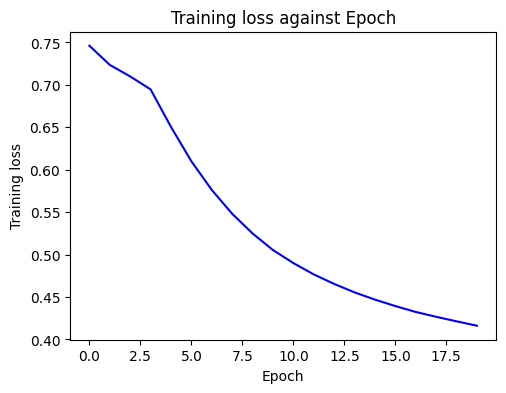

100%|███████████████████████████████████████████████████████████████████████████████| 730/730 [00:02<00:00, 257.45it/s]


              precision    recall  f1-score   support

           0     0.8064    0.8421    0.8238       361
           1     0.8385    0.8022    0.8199       369

    accuracy                         0.8219       730
   macro avg     0.8224    0.8221    0.8219       730
weighted avg     0.8226    0.8219    0.8219       730



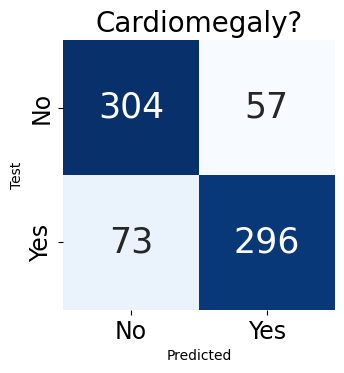

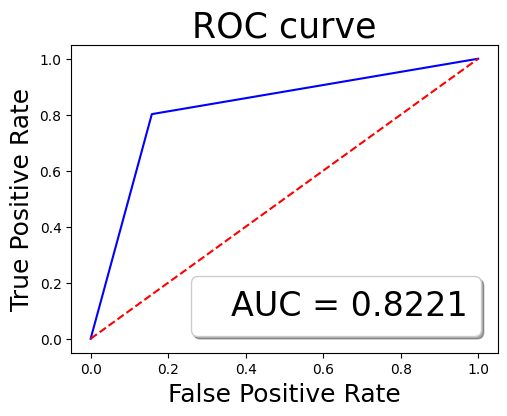

(3, 224, 224)


100%|█████████████████████████████████████████████████████████████████████████████| 1706/1706 [00:13<00:00, 127.19it/s]


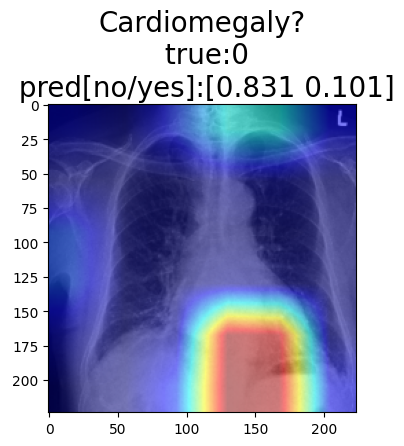

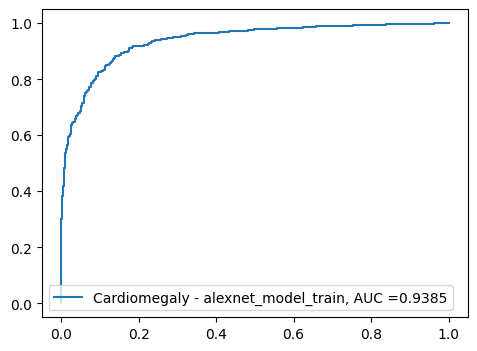

              precision    recall  f1-score   support

           0       0.89      0.83      0.86       856
           1       0.84      0.90      0.87       850

    accuracy                           0.86      1706
   macro avg       0.87      0.86      0.86      1706
weighted avg       0.87      0.86      0.86      1706



100%|███████████████████████████████████████████████████████████████████████████████| 730/730 [00:05<00:00, 131.35it/s]


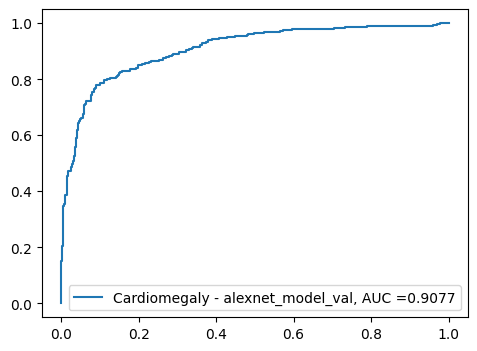

              precision    recall  f1-score   support

           0       0.84      0.80      0.82       369
           1       0.81      0.84      0.82       361

    accuracy                           0.82       730
   macro avg       0.82      0.82      0.82       730
weighted avg       0.82      0.82      0.82       730



In [24]:
alexnet_model = torchvision.models.alexnet(weights='DEFAULT')
for param in alexnet_model.parameters():
    param.requires_grad = False
alexnet_model.classifier.append(torch.nn.ReLU())
alexnet_model.classifier.append(nn.Linear(1000, 2))
#alexnet_model.classifier = nn.Sequential(nn.Linear(cnn_model.classifier[1].in_features, 512), torch.nn.ReLU(), nn.Linear(512, 2))
alexnet_model = train_func(alexnet_model, init_epochs, train_epochs)
for i in ['train','val']:
    exec(f"alexnet_model_{i}=make_csv(alexnet_model,'{i}')")

### Densenet 121 Pennylane hybird

name: PL_qnn_model
Transform Time elapsed:  2.58670973777771
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:07<00:00,  1.14it/s]

Train Epoch: 1/20 train loss 0.6373 Acc batch: 0.6671 learning_rate: 0.0010


Transform Time elapsed:  2.6750564575195312
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:07<00:00,  1.14it/s]

Train Epoch: 2/20 train loss 0.6644 Acc batch: 0.6166 learning_rate: 0.0010


Transform Time elapsed:  2.870159149169922
3 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:07<00:00,  1.14it/s]

Train Epoch: 3/20 train loss 0.6679 Acc batch: 0.6049 learning_rate: 0.0003


Transform Time elapsed:  2.757406234741211
4 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:05<00:00,  1.15it/s]

Train Epoch: 4/20 train loss 0.6297 Acc batch: 0.6852 learning_rate: 0.0003


Transform Time elapsed:  2.6545846462249756
5 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:07<00:00,  1.14it/s]

Train Epoch: 5/20 train loss 0.5448 Acc batch: 0.7550 learning_rate: 0.0001


Transform Time elapsed:  2.7081146240234375
6 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:06<00:00,  1.15it/s]

Train Epoch: 6/20 train loss 0.5108 Acc batch: 0.7843 learning_rate: 0.0001


Transform Time elapsed:  2.7525298595428467
7 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:06<00:00,  1.15it/s]

Train Epoch: 7/20 train loss 0.4896 Acc batch: 0.8001 learning_rate: 0.0000


Transform Time elapsed:  2.7181527614593506
8 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:06<00:00,  1.14it/s]

Train Epoch: 8/20 train loss 0.4707 Acc batch: 0.8247 learning_rate: 0.0000


Transform Time elapsed:  2.669455051422119
9 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:06<00:00,  1.15it/s]

Train Epoch: 9/20 train loss 0.4705 Acc batch: 0.8230 learning_rate: 0.0000


Transform Time elapsed:  2.6419472694396973
10 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:07<00:00,  1.14it/s]

Train Epoch: 10/20 train loss 0.4698 Acc batch: 0.8159 learning_rate: 0.0000


Transform Time elapsed:  2.7657296657562256
11 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:07<00:00,  1.14it/s]

Train Epoch: 11/20 train loss 0.4659 Acc batch: 0.8206 learning_rate: 0.0000


Transform Time elapsed:  2.73028826713562
12 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:05<00:00,  1.15it/s]

Train Epoch: 12/20 train loss 0.4684 Acc batch: 0.8242 learning_rate: 0.0000


Transform Time elapsed:  2.9341819286346436
13 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:05<00:00,  1.16it/s]

Train Epoch: 13/20 train loss 0.4589 Acc batch: 0.8335 learning_rate: 0.0000


Transform Time elapsed:  3.249850273132324
14 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:05<00:00,  1.15it/s]

Train Epoch: 14/20 train loss 0.4661 Acc batch: 0.8212 learning_rate: 0.0000


Transform Time elapsed:  2.7262182235717773
15 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [02:58<00:00,  1.20it/s]

Train Epoch: 15/20 train loss 0.4564 Acc batch: 0.8388 learning_rate: 0.0000


Transform Time elapsed:  2.6803178787231445
16 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [02:57<00:00,  1.20it/s]

Train Epoch: 16/20 train loss 0.4620 Acc batch: 0.8300 learning_rate: 0.0000


Transform Time elapsed:  2.6453514099121094
17 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [02:57<00:00,  1.20it/s]

Train Epoch: 17/20 train loss 0.4600 Acc batch: 0.8318 learning_rate: 0.0000


Transform Time elapsed:  2.6853413581848145
18 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [02:57<00:00,  1.21it/s]

Train Epoch: 18/20 train loss 0.4568 Acc batch: 0.8382 learning_rate: 0.0000


Transform Time elapsed:  2.714914321899414
19 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [02:57<00:00,  1.21it/s]

Train Epoch: 19/20 train loss 0.4597 Acc batch: 0.8294 learning_rate: 0.0000


Transform Time elapsed:  2.7985970973968506
20 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [02:57<00:00,  1.20it/s]

Train Epoch: 20/20 train loss 0.4569 Acc batch: 0.8312 learning_rate: 0.0000
Time elapsed:  3734.9068479537964


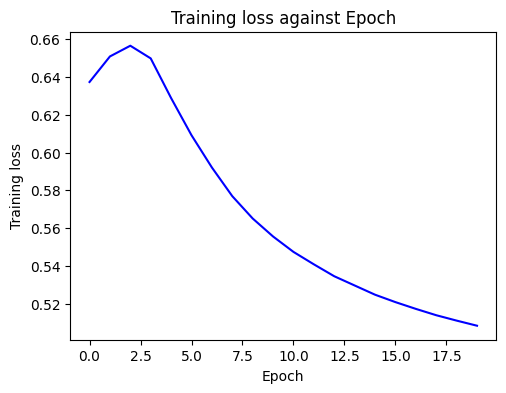

100%|████████████████████████████████████████████████████████████████████████████████| 730/730 [01:28<00:00,  8.27it/s]


              precision    recall  f1-score   support

           0     0.8940    0.7479    0.8145       361
           1     0.7874    0.9133    0.8457       369

    accuracy                         0.8315       730
   macro avg     0.8407    0.8306    0.8301       730
weighted avg     0.8401    0.8315    0.8302       730



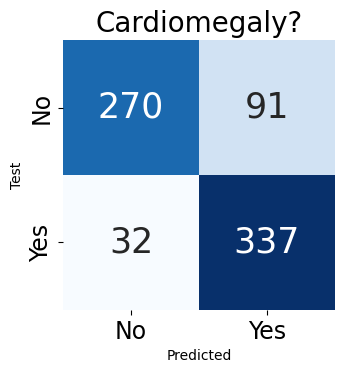

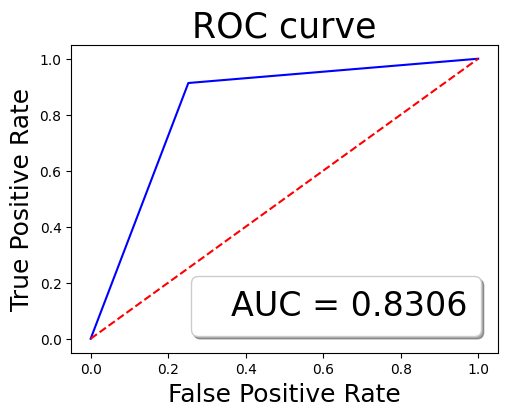

(3, 224, 224)


100%|██████████████████████████████████████████████████████████████████████████████| 1706/1706 [03:31<00:00,  8.08it/s]


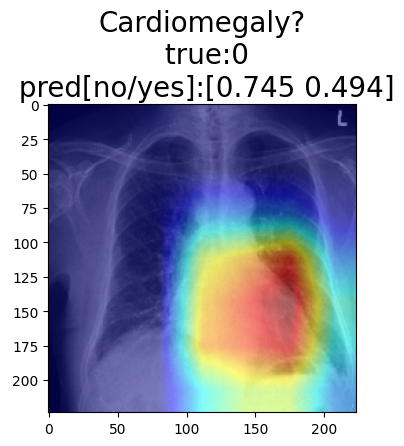

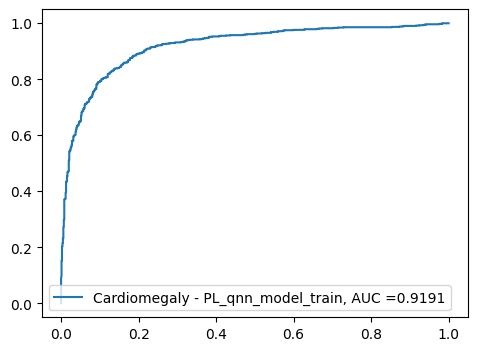

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       856
           1       0.89      0.77      0.83       850

    accuracy                           0.84      1706
   macro avg       0.85      0.84      0.84      1706
weighted avg       0.85      0.84      0.84      1706



100%|████████████████████████████████████████████████████████████████████████████████| 730/730 [01:30<00:00,  8.10it/s]


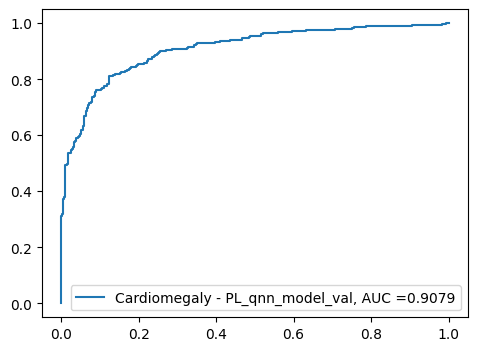

              precision    recall  f1-score   support

           0       0.79      0.91      0.85       369
           1       0.89      0.75      0.81       361

    accuracy                           0.83       730
   macro avg       0.84      0.83      0.83       730
weighted avg       0.84      0.83      0.83       730



In [25]:
class Quantumnet(nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.pre_net = nn.Linear(input_size, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(max_layers * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        pre_out = self.pre_net(input_features) 
        q_in = torch.tanh(pre_out) * np.pi / 2.0   
        
        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = q_net(elem,self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))
        return self.post_net(q_out)

PL_qnn_model = torchvision.models.densenet121(weights= 'DEFAULT')
for param in PL_qnn_model.parameters():
    param.requires_grad = False
PL_qnn_model.classifier = Quantumnet(PL_qnn_model.classifier.in_features)
 #quick_sum(qnn_model,torch.stack(train_imgg).shape[1:],device=device)
PL_qnn_model= train_func(PL_qnn_model, init_epochs, train_epochs)

'''
# Downgrade cuda driver if you meet this error:
nvrtc: error: failed to open nvrtc-builtins64_117.dll.
  Make sure that nvrtc-builtins64_117.dll is installed correctly.
'''

for i in ['train','val']:
    exec(f"PL_qnn_model_{i}=make_csv(PL_qnn_model,'{i}')")

### prepare for simulator

In [26]:
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap,EfficientSU2, PauliFeatureMap,TwoLocal,ZFeatureMap,NLocal
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN, OpflowQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow.gradients import Gradient, Hessian #, NaturalGradient, QFI, 
from qiskit import QuantumCircuit, transpile, Aer ,  execute, BasicAer, assemble, IBMQ
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.neural_networks import EffectiveDimension, LocalEffectiveDimension
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
input_dim = n_qubits

In [27]:
def simulator_train(feature_map, ansatz,effective=None,hardware='CPU',num_layer=0,output_dim=4):
    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qc = feature_map.compose(ansatz)
    simulator = Aer.get_backend('aer_simulator_statevector')
    # detail_explaination: https://qiskit.org/documentation/stubs/qiskit_aer.AerSimulator.html
    simulator.set_options(
        device=hardware,
        max_parallel_threads = 0, #max_parallel_shots
        max_parallel_experiments = 0, #equal 0 means maximum number of experiments that may be executed in parallel equals max_parallel_threads value.
        max_parallel_shots = 1, #equal 1 means disable parallel shot execution.
        statevector_parallel_threshold = input_dim,
        blocking_enable = True,
    )
    qnn = CircuitQNN(
                circuit=qc,
                input_params=feature_map.parameters,
                weight_params=ansatz.parameters,
                interpret=lambda x: x % output_dim,
                output_shape=output_dim,
                gradient= None,#Gradient(grad_method='lin_comb'), #param_shift
                quantum_instance= QuantumInstance(simulator, shots=10),
                input_gradients=True,
            )
    initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn.num_weights) - 1)
    model1 = TorchConnector(qnn, initial_weights=initial_weights)
    print(model1(torch.tensor(0.1 * (2 * algorithm_globals.random.random(input_dim) - 1))))
    if effective:
        # we can set the total number of input samples and weight samples for random selection
    
        global_ed = EffectiveDimension(
            qnn=qnn, weight_samples=10, input_samples=10
        )
        
        # finally, we will define ranges to test different numbers of data, n
        n = [5000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]
        #n = [1000, 2000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]
        global_eff_dim_0 = global_ed.get_effective_dimension(dataset_size=n[0])
        
        d = qnn.num_weights
        
        print("Data size: {}, global effective dimension: {:.4f}".format(n[0], global_eff_dim_0))
        print(
            "Number of weights: {}, normalized effective dimension: {:.4f}".format(d, global_eff_dim_0 / d)
        )
        
        global_eff_dim_1 = global_ed.get_effective_dimension(dataset_size=n)
        
        print("Effective dimension: {}".format(global_eff_dim_1))
        print("Number of weights: {}".format(d))
        
        # plot the normalized effective dimension for the model
        plt.plot(n, np.array(global_eff_dim_1) / d)
        plt.xlabel("Number of data")
        plt.ylabel("Normalized GLOBAL effective dimension")
        if save_result : plt.savefig(f"{result_OUT}/{effective}_effective.png")
        plt.show()
    class Quantumnet(nn.Module):
        def __init__(self,input_size):
            super().__init__()
            self.pre_net = nn.Linear(input_size, input_dim)
            #self.q_params = nn.Parameter(q_delta * torch.randn(max_layers * n_qubits))
            self.qnn = TorchConnector(qnn)#,initial_weights)
            for i in range(num_layer):
                exec(f"self.qnn{i}= TorchConnector(qnn{i})")
            self.post_net = nn.Linear(output_dim, 2)

        def forward(self, input_features):
            pre_out = self.pre_net(input_features)
            q_in = torch.tanh(pre_out) * np.pi / 2.0   
            q_out = self.qnn(q_in).float()
            #print(q_out)
            for i in range(num_layer):
                q_out = torch.tanh(q_out) * np.pi / 2.0  
                q_out = eval(f"self.qnn{i}().float()")
            
            # Apply the quantum circuit to each element of the batch and append to q_out
            #q_out = torch.Tensor(0, n_qubits)
            #q_out = q_out.to(device)
            return self.post_net(q_out)
    return Quantumnet

### Densenet Qiskit hybird easy qnn

In [28]:
parm = ParameterVector('phi', input_dim)
param = ParameterVector('deta',q_depth*input_dim)
feature_map = QuantumCircuit(input_dim)
feature_map.h(range(input_dim))
for i,j in enumerate(parm):
    feature_map.ry(j,i)
#for k in range(feature_map.num_qubits-1):
#    feature_map.cnot(k,k+1)
feature_map.barrier()

feature_map.draw()

ansatz = QuantumCircuit(input_dim)
k=0
for i in range(q_depth):
    for j in range(ansatz.num_qubits-1):
        ansatz.cnot(j,j+1)
    ansatz.barrier()
    
    for j in range(ansatz.num_qubits):
        ansatz.ry(param[k],j)
        k+=1
    ansatz.barrier()
print(ansatz.num_parameters)
feature_map.compose(ansatz).draw()

#feature_map = ZFeatureMap(input_dim,reps=1)
#ansatz = RealAmplitudes(input_dim, reps=q_depth,entanglement='linear',skip_final_rotation_layer=True,insert_barriers=True)
#feature_map.decompose(reps=1).draw()

24


┌───┐┌────────────┐ ░                 ░ ┌─────────────┐ ░                »
q_0: ┤ H ├┤ Ry(phi[0]) ├─░───■─────────────░─┤ Ry(deta[0]) ├─░───■────────────»
     ├───┤├────────────┤ ░ ┌─┴─┐           ░ ├─────────────┤ ░ ┌─┴─┐          »
q_1: ┤ H ├┤ Ry(phi[1]) ├─░─┤ X ├──■────────░─┤ Ry(deta[1]) ├─░─┤ X ├──■───────»
     ├───┤├────────────┤ ░ └───┘┌─┴─┐      ░ ├─────────────┤ ░ └───┘┌─┴─┐     »
q_2: ┤ H ├┤ Ry(phi[2]) ├─░──────┤ X ├──■───░─┤ Ry(deta[2]) ├─░──────┤ X ├──■──»
     ├───┤├────────────┤ ░      └───┘┌─┴─┐ ░ ├─────────────┤ ░      └───┘┌─┴─┐»
q_3: ┤ H ├┤ Ry(phi[3]) ├─░───────────┤ X ├─░─┤ Ry(deta[3]) ├─░───────────┤ X ├»
     └───┘└────────────┘ ░           └───┘ ░ └─────────────┘ ░           └───┘»
«      ░ ┌─────────────┐ ░                 ░ ┌─────────────┐  ░                »
«q_0: ─░─┤ Ry(deta[4]) ├─░───■─────────────░─┤ Ry(deta[8]) ├──░───■────────────»
«      ░ ├─────────────┤ ░ ┌─┴─┐           ░ ├─────────────┤  ░ ┌─┴─┐          »
«q_1: ─░─┤ Ry(deta[5]) ├─░─┤ X ├──■────────░─┤ Ry(deta[9]) ├──░─┤ X ├──■───────»
«      ░ ├─────────────┤ ░ └───┘┌─┴─┐      ░ ├─────────────┴┐ ░ └───┘┌─┴─┐     »
«q_2: ─░─┤ Ry(deta[6]) ├─░──────┤ X ├──■───░─┤ Ry(deta[10]) ├─░──────┤ X ├──■──»
«      ░ ├─────────────┤ ░      └───┘┌─┴─┐ ░ ├──────────────┤ ░      └───┘┌─┴─┐»
«q_3: ─░─┤ Ry(deta[7]) ├─░───────────┤ X ├─░─┤ Ry(deta[11]) ├─░───────────┤ X ├»
«      ░ └─────────────┘ ░           └───┘ ░ └──────────────┘ ░           └───┘»
«      ░ ┌──────────────┐ ░                 ░ ┌──────────────┐ ░           »
«q_0: ─░─┤ Ry(deta[12]) ├─░───■─────────────░─┤ Ry(deta[16]) ├─░───■───────»
«      ░ ├──────────────┤ ░ ┌─┴─┐           ░ ├──────────────┤ ░ ┌─┴─┐     »
«q_1: ─░─┤ Ry(deta[13]) ├─░─┤ X ├──■────────░─┤ Ry(deta[17]) ├─░─┤ X ├──■──»
«      ░ ├──────────────┤ ░ └───┘┌─┴─┐      ░ ├──────────────┤ ░ └───┘┌─┴─┐»
«q_2: ─░─┤ Ry(deta[14]) ├─░──────┤ X ├──■───░─┤ Ry(deta[18]) ├─░──────┤ X ├»
«      ░ ├──────────────┤ ░      └───┘┌─┴─┐ ░ ├──────────────┤ ░      └───┘»
«q_3: ─░─┤ Ry(deta[15]) ├─░───────────┤ X ├─░─┤ Ry(deta[19]) ├─░───────────»
«      ░ └──────────────┘ ░           └───┘ ░ └──────────────┘ ░           »
«           ░ ┌──────────────┐ ░ 
«q_0: ──────░─┤ Ry(deta[20]) ├─░─
«           ░ ├──────────────┤ ░ 
«q_1: ──────░─┤ Ry(deta[21]) ├─░─
«           ░ ├──────────────┤ ░ 
«q_2: ──■───░─┤ Ry(deta[22]) ├─░─
«     ┌─┴─┐ ░ ├──────────────┤ ░ 
«q_3: ┤ X ├─░─┤ Ry(deta[23]) ├─░─
«     └───┘ ░ └──────────────┘ ░

#### 2 Dim

tensor([0.5061, 0.4939], grad_fn=<_TorchNNFunctionBackward>)
Data size: 5000, global effective dimension: 9.6953
Number of weights: 24, normalized effective dimension: 0.4040
Effective dimension: [9.6953114  9.69311702 9.69528483 9.72829152 9.73984652 9.75404841
 9.76477435 9.77202686 9.79302535 9.80686333]
Number of weights: 24


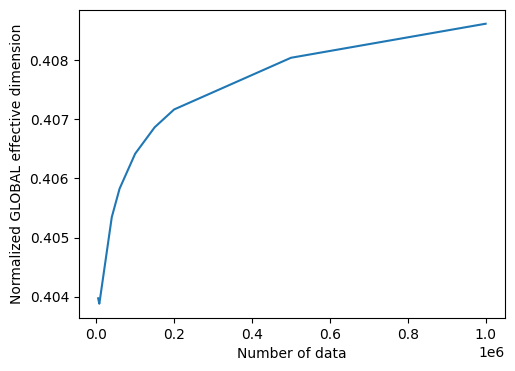

In [29]:
Quantumnet = simulator_train(feature_map, ansatz,'easy-2',output_dim=2)

name: Qiskit_easy_2_qnn_model
Transform Time elapsed:  2.6358911991119385
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:41<00:00,  3.00s/it]

Train Epoch: 1/20 train loss 0.6971 Acc batch: 0.4982 learning_rate: 0.0010


Transform Time elapsed:  3.858668804168701
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:36<00:00,  2.97s/it]

Train Epoch: 2/20 train loss 0.6930 Acc batch: 0.5275 learning_rate: 0.0010


Transform Time elapsed:  3.618379592895508
3 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:41<00:00,  3.00s/it]

Train Epoch: 3/20 train loss 0.6900 Acc batch: 0.5428 learning_rate: 0.0003


Transform Time elapsed:  3.5751490592956543
4 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:39<00:00,  2.99s/it]

Train Epoch: 4/20 train loss 0.6789 Acc batch: 0.6049 learning_rate: 0.0003


Transform Time elapsed:  3.6017301082611084
5 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:30<00:00,  2.95s/it]

Train Epoch: 5/20 train loss 0.6569 Acc batch: 0.7093 learning_rate: 0.0001


Transform Time elapsed:  3.5277626514434814
6 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:47<00:00,  3.02s/it]

Train Epoch: 6/20 train loss 0.6491 Acc batch: 0.7181 learning_rate: 0.0001


Transform Time elapsed:  3.513554811477661
7 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:43<00:00,  3.01s/it]

Train Epoch: 7/20 train loss 0.6362 Acc batch: 0.7573 learning_rate: 0.0000


Transform Time elapsed:  3.548841714859009
8 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:40<00:00,  2.99s/it]

Train Epoch: 8/20 train loss 0.6332 Acc batch: 0.7632 learning_rate: 0.0000


Transform Time elapsed:  3.6488280296325684
9 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:46<00:00,  3.02s/it]

Train Epoch: 9/20 train loss 0.6265 Acc batch: 0.7860 learning_rate: 0.0000


Transform Time elapsed:  3.608761787414551
10 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:43<00:00,  3.01s/it]

Train Epoch: 10/20 train loss 0.6265 Acc batch: 0.7784 learning_rate: 0.0000


Transform Time elapsed:  3.8503336906433105
11 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:44<00:00,  3.01s/it]

Train Epoch: 11/20 train loss 0.6268 Acc batch: 0.7778 learning_rate: 0.0000


Transform Time elapsed:  3.6552531719207764
12 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:40<00:00,  2.99s/it]

Train Epoch: 12/20 train loss 0.6246 Acc batch: 0.7837 learning_rate: 0.0000


Transform Time elapsed:  3.5923638343811035
13 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:44<00:00,  3.01s/it]

Train Epoch: 13/20 train loss 0.6262 Acc batch: 0.7819 learning_rate: 0.0000


Transform Time elapsed:  3.5758979320526123
14 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:46<00:00,  3.02s/it]

Train Epoch: 14/20 train loss 0.6245 Acc batch: 0.7849 learning_rate: 0.0000


Transform Time elapsed:  3.6445870399475098
15 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:42<00:00,  3.00s/it]

Train Epoch: 15/20 train loss 0.6249 Acc batch: 0.7837 learning_rate: 0.0000


Transform Time elapsed:  3.4648971557617188
16 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:45<00:00,  3.02s/it]

Train Epoch: 16/20 train loss 0.6255 Acc batch: 0.7825 learning_rate: 0.0000


Transform Time elapsed:  3.7033026218414307
17 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:43<00:00,  3.01s/it]

Train Epoch: 17/20 train loss 0.6245 Acc batch: 0.7831 learning_rate: 0.0000


Transform Time elapsed:  3.7027599811553955
18 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:46<00:00,  3.02s/it]

Train Epoch: 18/20 train loss 0.6250 Acc batch: 0.7866 learning_rate: 0.0000


Transform Time elapsed:  4.119321823120117
19 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:38<00:00,  2.98s/it]

Train Epoch: 19/20 train loss 0.6247 Acc batch: 0.7878 learning_rate: 0.0000


Transform Time elapsed:  3.669135808944702
20 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:41<00:00,  3.00s/it]

Train Epoch: 20/20 train loss 0.6248 Acc batch: 0.7819 learning_rate: 0.0000
Time elapsed:  12916.418677568436


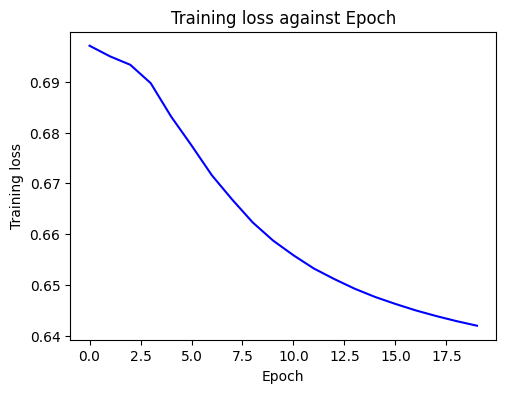

100%|████████████████████████████████████████████████████████████████████████████████| 730/730 [01:06<00:00, 10.90it/s]


              precision    recall  f1-score   support

           0     0.7538    0.8227    0.7868       361
           1     0.8095    0.7371    0.7716       369

    accuracy                         0.7795       730
   macro avg     0.7817    0.7799    0.7792       730
weighted avg     0.7820    0.7795    0.7791       730



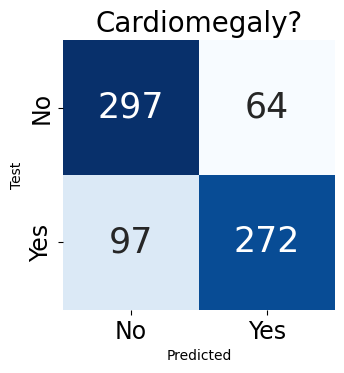

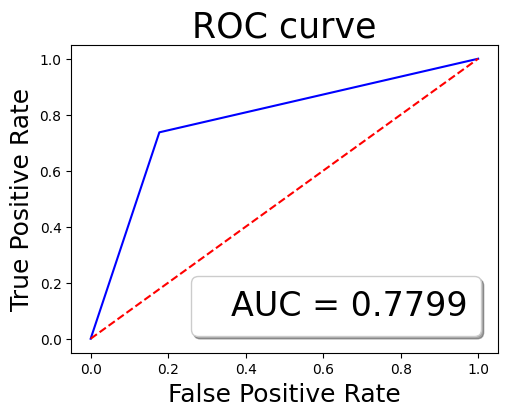

(3, 224, 224)


100%|██████████████████████████████████████████████████████████████████████████████| 1706/1706 [02:44<00:00, 10.35it/s]


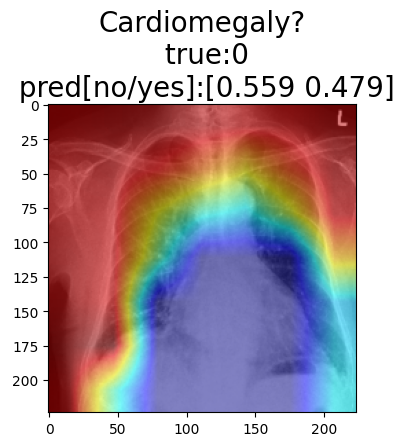

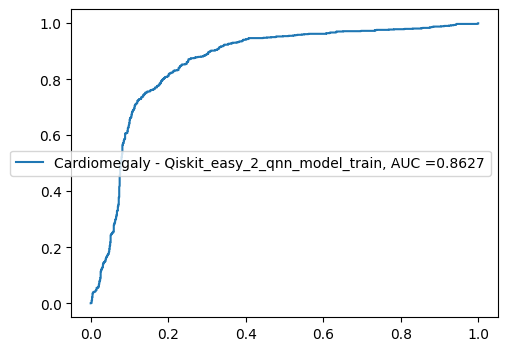

              precision    recall  f1-score   support

           0       0.84      0.77      0.80       856
           1       0.78      0.85      0.82       850

    accuracy                           0.81      1706
   macro avg       0.81      0.81      0.81      1706
weighted avg       0.81      0.81      0.81      1706



100%|████████████████████████████████████████████████████████████████████████████████| 730/730 [01:11<00:00, 10.15it/s]


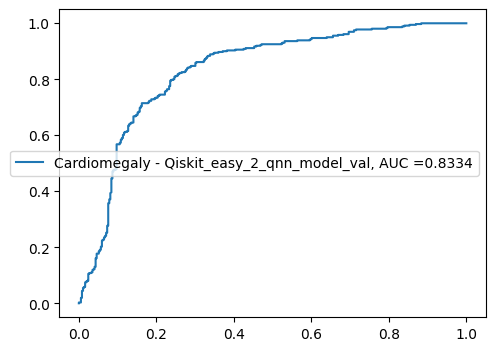

              precision    recall  f1-score   support

           0       0.81      0.74      0.77       369
           1       0.75      0.82      0.79       361

    accuracy                           0.78       730
   macro avg       0.78      0.78      0.78       730
weighted avg       0.78      0.78      0.78       730



In [30]:
Qiskit_easy_2_qnn_model = torchvision.models.densenet121(weights= 'DEFAULT')
for param in Qiskit_easy_2_qnn_model.parameters():
    param.requires_grad = False
Qiskit_easy_2_qnn_model.classifier = Quantumnet(Qiskit_easy_2_qnn_model.classifier.in_features)
Qiskit_easy_2_qnn_model = train_func(Qiskit_easy_2_qnn_model, init_epochs, train_epochs)
for i in ['train','val']:
    exec(f"Qiskit_easy_2_qnn_model_{i}=make_csv(Qiskit_easy_2_qnn_model,'{i}')")

#### 4 Dim

tensor([0.2592, 0.2328, 0.2244, 0.2836], grad_fn=<_TorchNNFunctionBackward>)
Data size: 5000, global effective dimension: 16.7055
Number of weights: 24, normalized effective dimension: 0.6961
Effective dimension: [16.70551827 16.9358331  17.04528146 17.6790905  17.84197255 18.03103713
 18.16867992 18.26001848 18.51924705 18.68736529]
Number of weights: 24


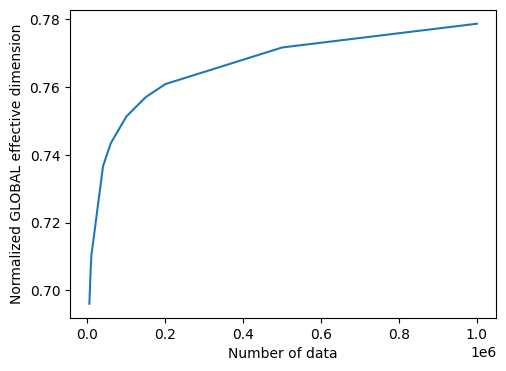

In [31]:
Quantumnet = simulator_train(feature_map, ansatz,'easy-4',output_dim=4)

name: Qiskit_easy_4_qnn_model
Transform Time elapsed:  3.609497308731079
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:57<00:00,  3.07s/it]

Train Epoch: 1/20 train loss 0.6824 Acc batch: 0.5856 learning_rate: 0.0010


Transform Time elapsed:  3.6822659969329834
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:51<00:00,  3.05s/it]

Train Epoch: 2/20 train loss 0.6623 Acc batch: 0.6483 learning_rate: 0.0010


Transform Time elapsed:  3.577641010284424
3 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:51<00:00,  3.04s/it]

Train Epoch: 3/20 train loss 0.6625 Acc batch: 0.6260 learning_rate: 0.0003


Transform Time elapsed:  3.6647109985351562
4 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:46<00:00,  3.02s/it]

Train Epoch: 4/20 train loss 0.6510 Acc batch: 0.6477 learning_rate: 0.0003


Transform Time elapsed:  3.6026790142059326
5 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:55<00:00,  3.06s/it]

Train Epoch: 5/20 train loss 0.6084 Acc batch: 0.7444 learning_rate: 0.0001


Transform Time elapsed:  3.5914056301116943
6 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:52<00:00,  3.05s/it]

Train Epoch: 6/20 train loss 0.6006 Acc batch: 0.7456 learning_rate: 0.0001


Transform Time elapsed:  3.3010621070861816
7 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:56<00:00,  3.07s/it]

Train Epoch: 7/20 train loss 0.5820 Acc batch: 0.7849 learning_rate: 0.0000


Transform Time elapsed:  4.0644543170928955
8 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:55<00:00,  3.06s/it]

Train Epoch: 8/20 train loss 0.5805 Acc batch: 0.7878 learning_rate: 0.0000


Transform Time elapsed:  3.7950921058654785
9 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:44<00:00,  3.01s/it]

Train Epoch: 9/20 train loss 0.5751 Acc batch: 0.7972 learning_rate: 0.0000


Transform Time elapsed:  3.645472526550293
10 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:53<00:00,  3.06s/it]

Train Epoch: 10/20 train loss 0.5685 Acc batch: 0.8101 learning_rate: 0.0000


Transform Time elapsed:  3.674943685531616
11 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:47<00:00,  3.03s/it]

Train Epoch: 11/20 train loss 0.5711 Acc batch: 0.8007 learning_rate: 0.0000


Transform Time elapsed:  3.7085835933685303
12 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:35<00:00,  2.97s/it]

Train Epoch: 12/20 train loss 0.5713 Acc batch: 0.7954 learning_rate: 0.0000


Transform Time elapsed:  3.672642946243286
13 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [11:02<00:00,  3.10s/it]

Train Epoch: 13/20 train loss 0.5692 Acc batch: 0.8036 learning_rate: 0.0000


Transform Time elapsed:  3.70402193069458
14 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:58<00:00,  3.08s/it]

Train Epoch: 14/20 train loss 0.5723 Acc batch: 0.8001 learning_rate: 0.0000


Transform Time elapsed:  3.5313477516174316
15 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:53<00:00,  3.05s/it]

Train Epoch: 15/20 train loss 0.5735 Acc batch: 0.7960 learning_rate: 0.0000


Transform Time elapsed:  3.658161163330078
16 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:46<00:00,  3.02s/it]

Train Epoch: 16/20 train loss 0.5675 Acc batch: 0.8107 learning_rate: 0.0000


Transform Time elapsed:  4.455501317977905
17 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:58<00:00,  3.08s/it]

Train Epoch: 17/20 train loss 0.5701 Acc batch: 0.7978 learning_rate: 0.0000


Transform Time elapsed:  4.021124839782715
18 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:36<00:00,  2.98s/it]

Train Epoch: 18/20 train loss 0.5674 Acc batch: 0.8060 learning_rate: 0.0000


Transform Time elapsed:  3.814350128173828
19 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:07<00:00,  2.84s/it]

Train Epoch: 19/20 train loss 0.5707 Acc batch: 0.8025 learning_rate: 0.0000


Transform Time elapsed:  3.792623281478882
20 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:15<00:00,  2.88s/it]

Train Epoch: 20/20 train loss 0.5700 Acc batch: 0.8036 learning_rate: 0.0000
Time elapsed:  13023.403673887253


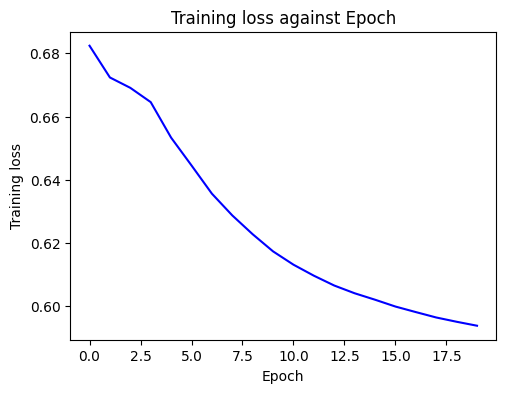

100%|████████████████████████████████████████████████████████████████████████████████| 730/730 [01:03<00:00, 11.57it/s]


              precision    recall  f1-score   support

           0     0.8225    0.7701    0.7954       361
           1     0.7883    0.8374    0.8121       369

    accuracy                         0.8041       730
   macro avg     0.8054    0.8037    0.8038       730
weighted avg     0.8052    0.8041    0.8038       730



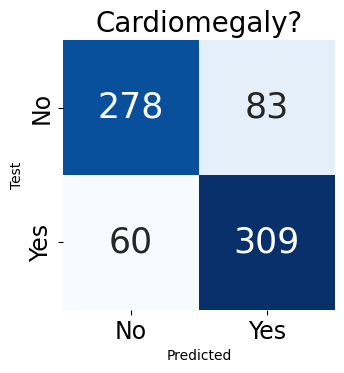

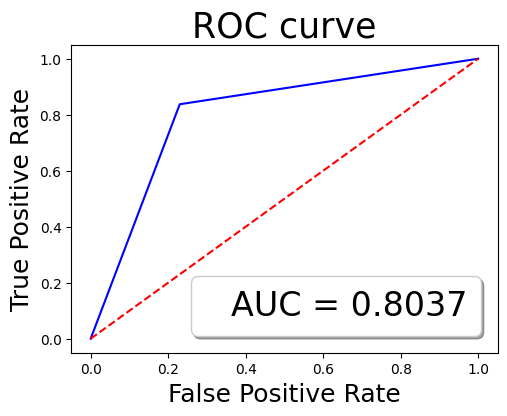

(3, 224, 224)


100%|██████████████████████████████████████████████████████████████████████████████| 1706/1706 [02:39<00:00, 10.66it/s]


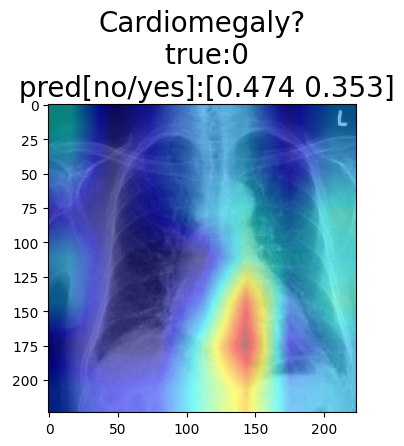

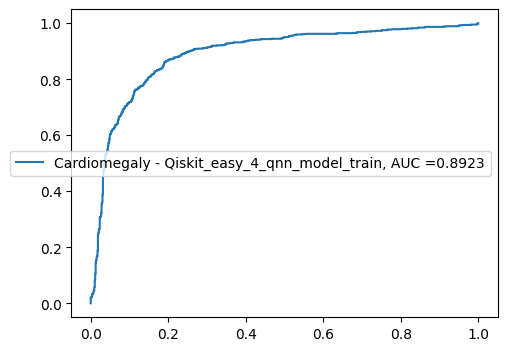

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       856
           1       0.84      0.81      0.82       850

    accuracy                           0.83      1706
   macro avg       0.83      0.83      0.83      1706
weighted avg       0.83      0.83      0.83      1706



100%|████████████████████████████████████████████████████████████████████████████████| 730/730 [01:10<00:00, 10.29it/s]


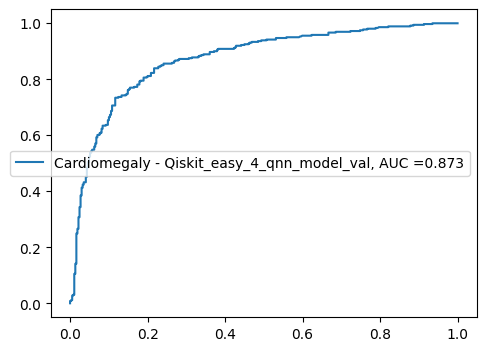

              precision    recall  f1-score   support

           0       0.79      0.84      0.81       369
           1       0.82      0.77      0.80       361

    accuracy                           0.80       730
   macro avg       0.81      0.80      0.80       730
weighted avg       0.81      0.80      0.80       730



In [32]:
Qiskit_easy_4_qnn_model = torchvision.models.densenet121(weights= 'DEFAULT')
for param in Qiskit_easy_4_qnn_model.parameters():
    param.requires_grad = False
Qiskit_easy_4_qnn_model.classifier = Quantumnet(Qiskit_easy_4_qnn_model.classifier.in_features)
Qiskit_easy_4_qnn_model = train_func(Qiskit_easy_4_qnn_model, init_epochs, train_epochs)
for i in ['train','val']:
    exec(f"Qiskit_easy_4_qnn_model_{i}=make_csv(Qiskit_easy_4_qnn_model,'{i}')")

In [33]:
total_train_time = time.time() - start_time
print("Time elapsed: ", total_train_time)

Time elapsed:  32313.04959821701
